# Modeling - COVID Image Classification

### This notebook was run in Google Colab

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import class_weight

np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/TOP\ 2023\ DSI/image\ detection/data/rdt.zip

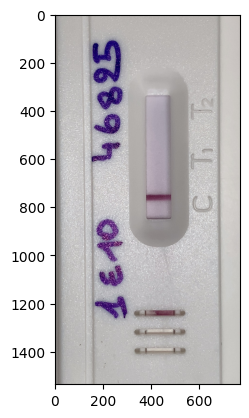

In [18]:
plt.imshow(plt.imread('/content/Images/NEGATIVE/JPEG image-08B1EEC706E7-10.jpeg'));

> The above is an example of a negative image.

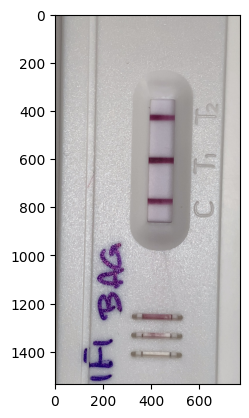

In [19]:
plt.imshow(plt.imread('/content/Images/POSITIVE/JPEG image-08B1EEC706E7-8.jpeg'));

> The above is an example of a positive test image.

In [90]:
datagen = ImageDataGenerator(validation_split=0.2)

In [100]:
train_gen = datagen.flow_from_directory(
    '/content/Images',
    class_mode='binary',
    batch_size=32,
    target_size=(256,256),
    shuffle=True,
    subset='training',
)

test_gen = datagen.flow_from_directory(
    '/content/Images',
    class_mode='binary',
    batch_size=32,
    target_size=(256,256),
    shuffle=False,
    subset='validation'
)

Found 2031 images belonging to 2 classes.
Found 507 images belonging to 2 classes.


In [92]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_gen.classes),
            y = train_gen.classes)

train_class_weights = dict(enumerate(class_weights))

In [31]:
train_gen.class_indices.keys()

dict_keys(['NEGATIVE', 'POSITIVE'])

In [22]:
classes = [k for k,v in train_gen.class_indices.items()]
classes

['NEGATIVE', 'POSITIVE']

In [23]:
new_dict={}
for key, value in train_gen.class_indices.items():
    new_dict[value]=key

new_dict

{0: 'NEGATIVE', 1: 'POSITIVE'}

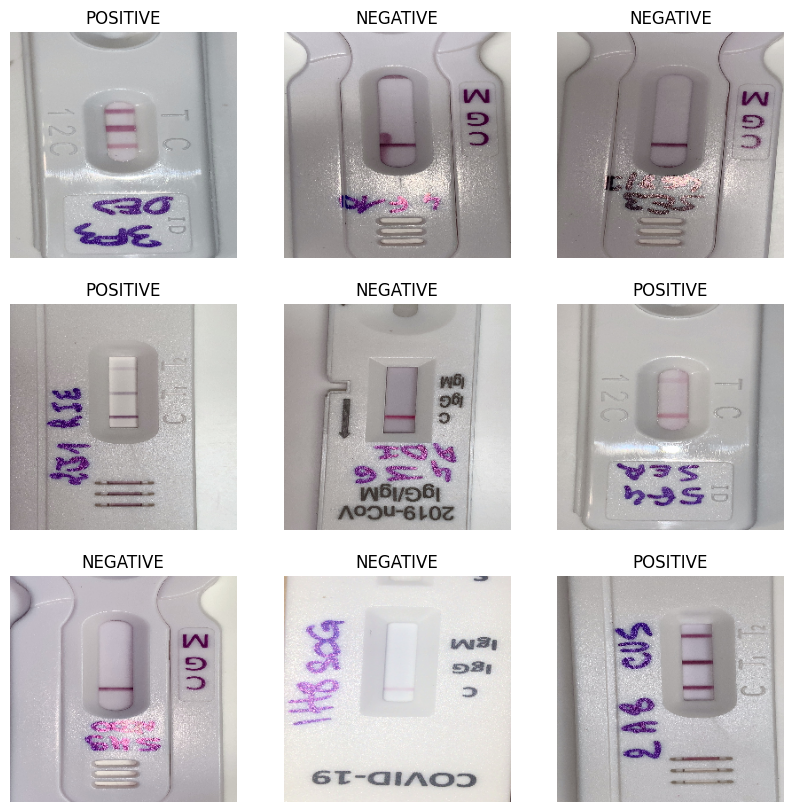

In [24]:
images, labels = train_gen.next()
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    label_name = label_name = new_dict[labels[i]]
    ax.imshow(images[i])
    ax.set_title(label_name)
    ax.axis('off')

In [98]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [94]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
)

In [101]:
history = model1.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
64/64 [==============================] - 25s 367ms/step - loss: 39.4731 - accuracy: 0.5583 - val_loss: 3.7864 - val_accuracy: 0.5542
Epoch 2/10
64/64 [==============================] - 24s 369ms/step - loss: 0.7862 - accuracy: 0.7578 - val_loss: 2.2783 - val_accuracy: 0.5759
Epoch 3/10
64/64 [==============================] - 25s 395ms/step - loss: 0.4601 - accuracy: 0.8163 - val_loss: 2.7645 - val_accuracy: 0.5996
Epoch 4/10
64/64 [==============================] - 24s 377ms/step - loss: 0.2426 - accuracy: 0.9124 - val_loss: 1.4719 - val_accuracy: 0.6391
Epoch 5/10
64/64 [==============================] - 23s 358ms/step - loss: 0.1112 - accuracy: 0.9522 - val_loss: 1.3762 - val_accuracy: 0.6805
Epoch 6/10
64/64 [==============================] - 23s 365ms/step - loss: 0.0872 - accuracy: 0.9641 - val_loss: 1.6872 - val_accuracy: 0.6667
Epoch 7/10
64/64 [==============================] - 24s 380ms/step - loss: 0.0635 - accuracy: 0.9744 - val_loss: 2.0192 - val_accuracy: 0.686

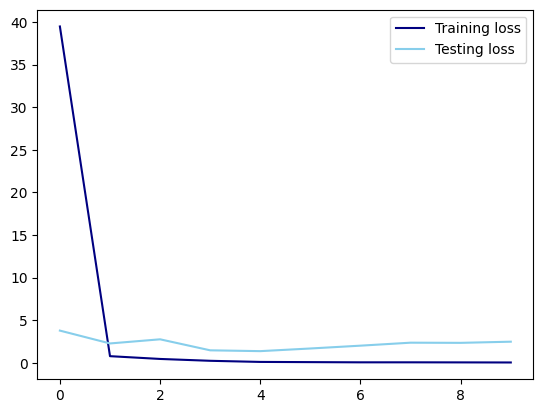

In [102]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

16/16 [==============================] - 8s 506ms/step


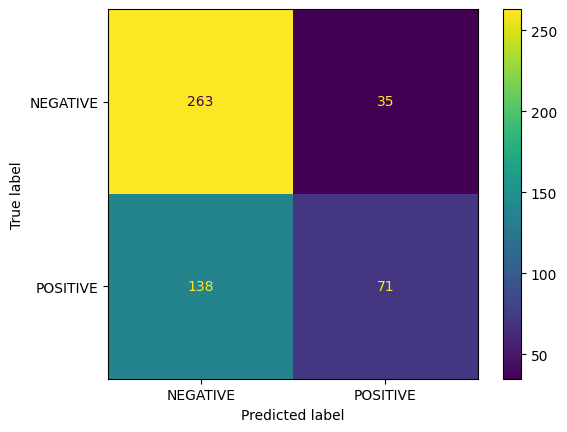

In [126]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes,
    np.where(model1.predict(test_gen) > 0.5, 1, 0),
    display_labels=list(test_gen.class_indices.keys()));

In [104]:
model2 = Sequential()
model2.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dense(1,activation='sigmoid', kernel_regularizer=l2(0.001)))

model2.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [105]:
history2 = model2.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
64/64 [==============================] - 26s 378ms/step - loss: 5.5582 - accuracy: 0.6169 - val_loss: 0.9777 - val_accuracy: 0.5503
Epoch 2/50
64/64 [==============================] - 23s 367ms/step - loss: 0.6802 - accuracy: 0.7189 - val_loss: 1.0148 - val_accuracy: 0.5740
Epoch 3/50
64/64 [==============================] - 24s 369ms/step - loss: 0.5072 - accuracy: 0.7789 - val_loss: 0.9582 - val_accuracy: 0.6252
Epoch 4/50
64/64 [==============================] - 22s 348ms/step - loss: 0.4151 - accuracy: 0.8400 - val_loss: 1.1143 - val_accuracy: 0.6351
Epoch 5/50
64/64 [==============================] - 23s 362ms/step - loss: 0.3384 - accuracy: 0.8848 - val_loss: 1.0981 - val_accuracy: 0.6213
Epoch 6/50
64/64 [==============================] - 24s 375ms/step - loss: 0.2917 - accuracy: 0.8986 - val_loss: 1.4404 - val_accuracy: 0.6450
Epoch 7/50
64/64 [==============================] - 23s 355ms/step - loss: 0.2355 - accuracy: 0.9252 - val_loss: 1.1723 - val_accuracy: 0.6509

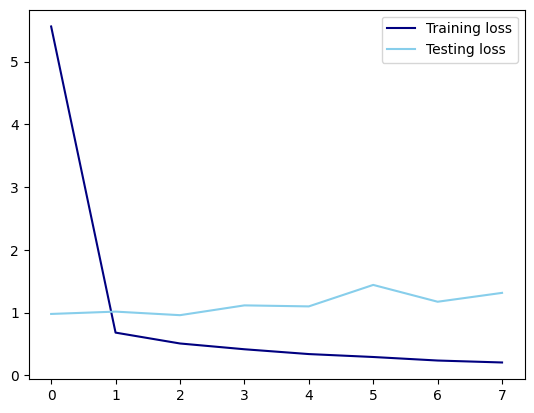

In [106]:
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

16/16 [==============================] - 7s 400ms/step


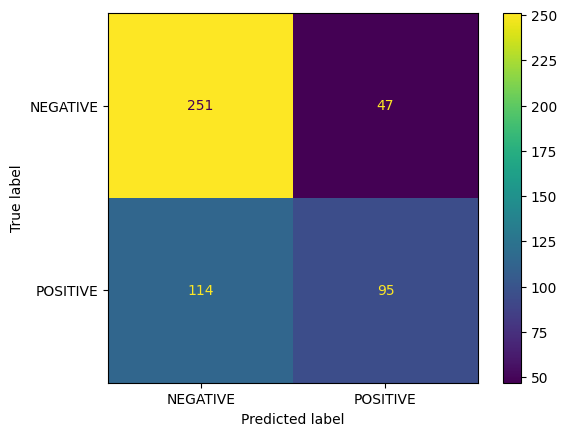

In [125]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes,
    np.where(model2.predict(test_gen) > 0.5, 1, 0),
    display_labels=list(test_gen.class_indices.keys()));

In [108]:
model3 = Sequential()
model3.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(128,activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid', kernel_regularizer=l2(0.001)))

model3.compile(
    optimizer =Adam(learning_rate=0.001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [109]:
history3 = model3.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
64/64 [==============================] - 26s 361ms/step - loss: 29.3913 - accuracy: 0.5421 - val_loss: 0.8569 - val_accuracy: 0.5602
Epoch 2/50
64/64 [==============================] - 23s 363ms/step - loss: 0.8397 - accuracy: 0.5997 - val_loss: 0.9062 - val_accuracy: 0.4320
Epoch 3/50
64/64 [==============================] - 24s 370ms/step - loss: 0.7972 - accuracy: 0.6598 - val_loss: 0.8420 - val_accuracy: 0.6351
Epoch 4/50
64/64 [==============================] - 23s 367ms/step - loss: 0.7267 - accuracy: 0.7174 - val_loss: 0.8810 - val_accuracy: 0.6588
Epoch 5/50
64/64 [==============================] - 24s 370ms/step - loss: 0.6382 - accuracy: 0.7715 - val_loss: 0.9449 - val_accuracy: 0.6450
Epoch 6/50
64/64 [==============================] - 23s 351ms/step - loss: 0.5927 - accuracy: 0.8134 - val_loss: 0.8671 - val_accuracy: 0.6410
Epoch 7/50
64/64 [==============================] - 23s 360ms/step - loss: 0.5694 - accuracy: 0.8291 - val_loss: 1.3016 - val_accuracy: 0.654

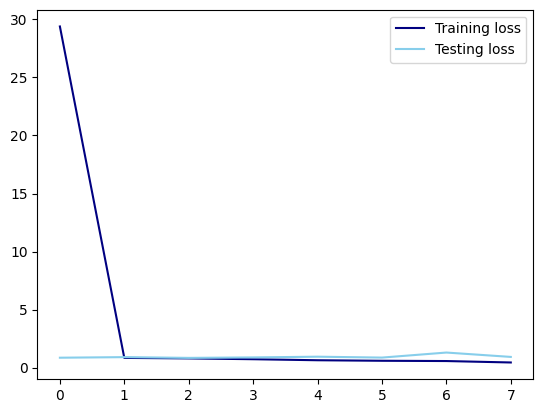

In [110]:
train_loss = history3.history['loss']
test_loss = history3.history['val_loss']

plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

16/16 [==============================] - 5s 326ms/step


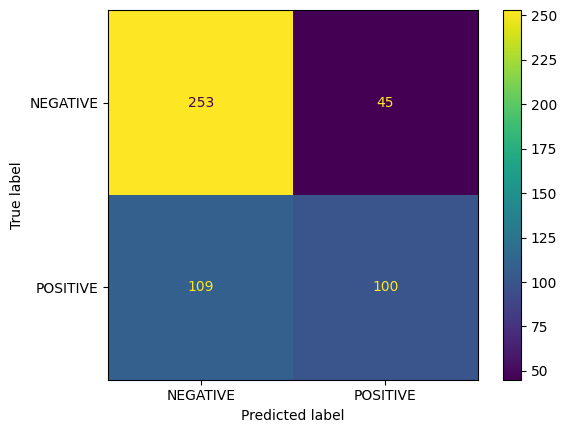

In [124]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes,
    np.where(model3.predict(test_gen) > 0.5, 1, 0),
    display_labels=list(test_gen.class_indices.keys()));

### EfficientNet Transfer Learning

In [112]:
eff_train = datagen.flow_from_directory(
    '/content/Images',
    class_mode='binary',
    target_size=(224,224),
    subset='training',
    seed=42
)

eff_test = datagen.flow_from_directory(
    '/content/Images',
    class_mode='binary',
    target_size=(224,224),
    subset='validation',
    seed=42
)

Found 2031 images belonging to 2 classes.
Found 507 images belonging to 2 classes.


In [113]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

In [114]:
effnet.trainable = False

In [115]:
model4 = Sequential()
model4.add(effnet)
model4.add(GlobalAveragePooling2D())
# model4.add(Dense(128,activation='relu', kernel_regularizer=l2(0.001)))
model4.add(Dense(1,activation='sigmoid'))

model4.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [116]:
history4 = model4.fit(
    eff_train,
    validation_data=eff_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
64/64 [==============================] - 31s 379ms/step - loss: 0.6628 - accuracy: 0.6076 - val_loss: 0.6526 - val_accuracy: 0.6331
Epoch 2/100
64/64 [==============================] - 23s 365ms/step - loss: 0.6238 - accuracy: 0.6553 - val_loss: 0.6360 - val_accuracy: 0.6529
Epoch 3/100
64/64 [==============================] - 21s 336ms/step - loss: 0.5945 - accuracy: 0.7105 - val_loss: 0.6241 - val_accuracy: 0.6391
Epoch 4/100
64/64 [==============================] - 23s 356ms/step - loss: 0.5676 - accuracy: 0.7459 - val_loss: 0.6148 - val_accuracy: 0.6371
Epoch 5/100
64/64 [==============================] - 28s 443ms/step - loss: 0.5457 - accuracy: 0.7740 - val_loss: 0.6079 - val_accuracy: 0.6430
Epoch 6/100
64/64 [==============================] - 23s 362ms/step - loss: 0.5255 - accuracy: 0.7937 - val_loss: 0.6008 - val_accuracy: 0.6568
Epoch 7/100
64/64 [==============================] - 22s 338ms/step - loss: 0.5069 - accuracy: 0.8065 - val_loss: 0.5997 - val_accuracy:

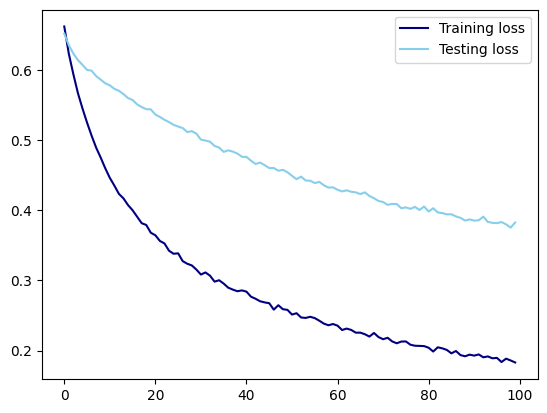

In [117]:
train_loss = history4.history['loss']
test_loss = history4.history['val_loss']

plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

16/16 [==============================] - 6s 352ms/step


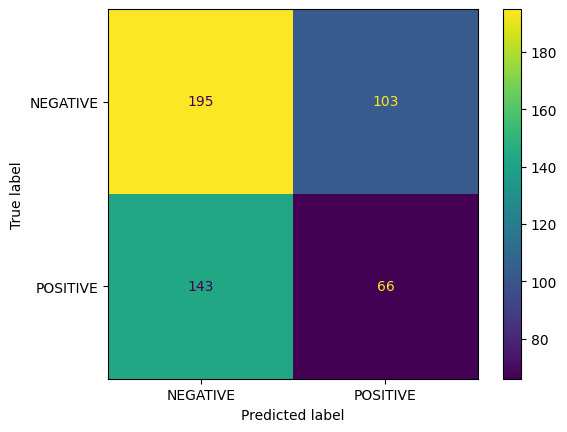

In [122]:
ConfusionMatrixDisplay.from_predictions(
    eff_test.classes,
    np.where(model4.predict(eff_test) > 0.5, 1, 0),
    display_labels=list(eff_test.class_indices.keys()));